## Cell type abundance analyses over age using linear mixed effect models (lme4)

In [3]:
library("data.table")
library("tidyverse")
library("ggpubr")
library("magrittr")
library("lme4")
library("numDeriv")
library("scales")
library("stringr")

In [33]:
figures_path = "/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/figures/"
tables_path = "/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/tables/"
source_files = "/nfs/team205/vk8/scripts/scvi/SKM_ageing_atlas_SourceFiles/"

In [8]:
options(repr.plot.width = 7, repr.plot.height = 8, repr.plot.res=150, repr.plot.pointsize=12)

In [6]:
## Load custom code (to modify some plotting parameters), also deposited as a package https://github.com/Teichlab/sctkr

In [7]:
# Method and initial implementation by Natsuhiko Kumasaka (natsuhiko@github)
# refactored and maintained by Ni Huang (nh3@github)

#' Make cell type by sample count matrix
#'
#' This function makes cell type by sample count matrix from a cell level annotation table
#'
#' @param obs_tbl Cell level annotation table, such as AnnData.obs (data.frame-like object)
#' @param colSample Column in "obs_tbl" specifying sample ID (str)
#' @param colCelltype Column in "obs_tbl" specifying cell type annotation (str)
#'
#' @return matrix containing cell type counts of dimension nSample x nCelltype
#'
#' @import magrittr
.make_count_matrix <- function(obs_tbl, colSample, colCelltype) {
  cnt_mat <- table(obs_tbl[[colSample]], obs_tbl[[colCelltype]]) %>% as.matrix()
  cnt_mat
}

#' Make sample level metadata table
#'
#' This function makes sample level metadata table from a cell level annotation table
#'
#' @param obs_tbl Cell level annotation table, such as AnnData.obs (data.frame-like object)
#' @param colSample Column in "obs_tbl" specifying sample ID (str)
#' @param colVarCats Columns in "obs_tbl" specifying categorical variables to control for (vector of str)
#' @param colVarNums Columns in "obs_tbl" specifying numerical variables to control for (vector of str)
#' @param extra_term Extra term(s) to be added to the model (str or vector of str)
#'
#' @return tibble containing metadata for each sample, one per row
#'
#' @import dplyr
.make_sample_metadata <- function(obs_tbl, colSample, colVarCats = c(), colVarNums = c(), extra_term = NULL) {
  if (!is.null(extra_term)) {
    extra_vars <- unique(unlist(strsplit(extra_term, ":", fixed = T)))
    extra_vars <- extra_vars[extra_vars %in% colnames(obs_tbl)]
  } else {
    extra_vars <- c()
  }
  metadata_tbl <- obs_tbl %>%
    select(one_of(unique(c(colSample, colVarCats, colVarNums, extra_vars)))) %>%
    unique()
  metadata_tbl
}

#' Make input data for model fitting
#'
#' This function makes input data for model fitting by assembling sample level
#' metadata and cell type by sample count matrix
#'
#' @param Y Cell type by sample count matrix (matrix of dimension nSample x nCelltype)
#' @param metadata_tbl Sample level metadata table (data.frame-like object)
#'
#' @return tibble containing counts and metadata for each cell type in each sample
#'
#' @import tibble
#' @import dplyr
.make_input_for_glmer <- function(Y, metadata_tbl, colSample) {
  samples <- rownames(Y)
  celltypes <- colnames(Y)
  nSample <- length(samples)
  nCelltype <- length(celltypes)

  metadata_tbl <- metadata_tbl[match(samples, metadata_tbl[[colSample]]), ]

  input_tbl <- bind_cols(
    metadata_tbl[rep(1:nSample, nCelltype), ],
    enframe(factor(rep(celltypes, rep(nSample, nCelltype))), name = NULL, value = "Celltype")
  )

  input_tbl$Y <- as.vector(Y)
  cat("input prepared\n")

  input_tbl
}

#' Make model formula
#'
#' This function makes a formula for a GLMM with random effects for each
#' specified categorical variables and interactions between each variable and
#' cell type
#'
#' @param colSample Column in "obs_tbl" specifying sample ID (str)
#' @param colVarCats Columns in "obs_tbl" specifying categorical variables to control for (vector of str)
#' @param colVarNums Columns in "obs_tbl" specifying numerical variables to control for (vector of str)
#' @param extra_term Extra term(s) to be added to the model (str or vector of str)
#'
#' @return formula specifying a GLMM model
.make_formula <- function(colSample, colCelltype, colVarCats, colVarNums, extra_term = NULL) {
  if (!is.null(extra_term)) {
    extra_vars <- unique(unlist(strsplit(extra_term, ":", fixed = T)))
    extra_vars[extra_vars == colCelltype] <- "Celltype"
    extra_term <- sprintf("(1|%s)", paste(extra_vars, collapse = ":"))
  }
  terms <- c(
    colVarNums,
    sprintf("(1|%s)", c(colSample, colVarCats)),
    sprintf("(%s-1|Celltype)", colVarNums),
    sprintf("(1|%s:Celltype)", c(colSample, colVarCats))
  )
  formula_str <- paste(c("I(Y) ~ (1|Celltype)", terms, extra_term), collapse = "+")
  cat(paste0(formula_str, "\n"))
  as.formula(formula_str)
}

#' Get mean estimate of random effects and LTSR values for all specified variables
#'
#' This function extracts random effect estimates (mean and sd) of specified
#' variables, calculates LTSR using a z-score test and prepare categories in
#' specified orders for plotting
#'
#' @param ranef_tbl Table of random effect estimates (mean and sd) extracted from fitted model
#'     (data.frame-like object)
#' @param vars A list specifying required categorical sample metadata variables and their order,
#'     e.g. list(size=c('small', 'medium', 'big'), price=c('cheap', 'expensive'))
#' @param celltypes If specified, only keep those cell types (vector of str)
#' @param references If specified, fold changes are calculated relative to the specified level
#'     instead of global mean. Must be a list, e.g. list(size='small', price='cheap')
#'
#' @return tibble containing mean random effects and respective LTSR
#'
#' @import dplyr
#' @import tidyr
#' @import stringr
.getCondValLtsr <- function(ranef_tbl, vars, celltypes = NULL, references = NULL) {
  if (!is.list(vars)) stop('"vars" must be a list of which names are co-variables to plot', call. = F)
  if (!is.null(references) && !is.list(references)) stop('"references" must be a list of which names match that of "vars"', call. = F)

  cat_ranef_tbl <- ranef_tbl %>%
    filter(
      grepl(":Celltype$", grpvar)
    ) %>%
    mutate(
      grpvar = factor(sub(":Celltype$", "", grpvar)),
      grp = factor(ifelse(
        grepl(":.*:", grp),
        sapply(str_split(grp, ":"), function(x) paste(paste(x[-length(x)], collapse = ","), x[length(x)], sep = ":")),
        as.character(grp)
      ))
    ) %>%
    separate(
      grp,
      into = c("grpval", "Celltype"), sep = ":"
    )

  num_ranef_tbl <- ranef_tbl %>%
    filter(
      grpvar == "Celltype" & term != "(Intercept)"
    ) %>%
    mutate(
      grpvar = factor(term),
      grpval= paste("Slope",term, sep = "-"),
      Celltype = grp
    ) %>%
    select (
      -grp
    )

  if (!is.null(references)) {
    cat_ranef_tbl <- bind_rows(
      lapply(names(vars), function(vname) {
        if (vname %in% names(references)) {
          ref <- references[[vname]]
          full_join(
            cat_ranef_tbl %>% filter(grpvar == vname, grpval != ref),
            cat_ranef_tbl %>% filter(grpvar == vname, grpval == ref) %>% select(grpvar, Celltype, condval, condsd),
            by = c("grpvar", "Celltype")
          ) %>%
            mutate(
              condval = condval.x - condval.y,
              condsd = sqrt(condsd.x^2 + condsd.y^2)
            ) %>%
            select(-condval.x, -condval.y, -condsd.x, -condsd.y)
        } else {
          return(cat_ranef_tbl %>% filter(grpvar == vname))
        }
      })
    )
  }

  ranef_tbl <- bind_rows(cat_ranef_tbl, num_ranef_tbl)

  ranef_tbl <- ranef_tbl %>%
    mutate(
      lfsr = pnorm(condval, 0, condsd)
    ) %>%
    mutate(
      lfsr = ifelse(lfsr > 0.5, 1 - lfsr, lfsr)
    ) %>%
    mutate(
      ltsr = 1 - lfsr
    ) %>%
    select(
      grpvar, grpval, Celltype, condval, ltsr
    )

  if (!is.null(celltypes)) ranef_tbl <- ranef_tbl %>% filter(Celltype %in% celltypes)

  ranef_tbl <- ranef_tbl %>%
    filter(
      grpvar %in% names(vars)
    ) %>%
    mutate(
      grpvar = factor(grpvar, levels = names(vars)),
      grpval = factor(grpval, levels = unlist(vars, use.names = F))
    )

  ranef_tbl
}

#' Cell type composition analysis
#'
#' This function performs cell type composition analysis across samples grouped by certain metadata
#' variable while controling for other variables, by fitting a Poisson Generalised Linear Mixed
#' Model
#'
#' @param obs_tbl Cell level annotation table, such as AnnData.obs (data.frame-like object)
#' @param colSample Column in "obs_tbl" specifying sample ID (str)
#' @param colCelltype Column in "obs_tbl" specifying cell type annotation (str)
#' @param colVarCats Columns in "obs_tbl" specifying categorical variables to control for (vector of str)
#' @param colVarNums Columns in "obs_tbl" specifying numerical variables to control for (vector of str)
#' @param extra_term Extra term(s) to be added to the model (str or vector of str)
#' @param save If specified, used as file name prefix to save returned values (str)
#'
#' @return list containing two tables, 1) estimated random effects, 2) estimated explained variance
#'     (in the form of standard deviation)
#'
#' @import tibble
#' @import dplyr
#' @import tidyr
#' @import lme4
#' @import numDeriv
#'
#' @export
CellTypeCompositionAnalysis <- function(obs_tbl, colSample, colCelltype, colVarCats, colVarNums = NULL, extra_term = NULL, save = NULL) {
  metadata_tbl <- .make_sample_metadata(obs_tbl, colSample, colVarCats, colVarNums, extra_term = extra_term)
  Y <- .make_count_matrix(obs_tbl, colSample, colCelltype)

  input_tbl <- .make_input_for_glmer(Y, metadata_tbl, colSample)

  f <- .make_formula(colSample, colCelltype, colVarCats, colVarNums, extra_term = extra_term)
  cat("model constructed\n")
  res.prop <- glmer(
    f,
    data = input_tbl, family = poisson,
    control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e5))
  )
  cat("model fitted\n")

  # standard errors of standard deviations (squre root of the variance parameters)
  devfun <- update(res.prop, devFunOnly = T)
  pars <- getME(res.prop, c("theta", "fixef"))
  hess <- hessian(devfun, unlist(pars))
  sdse.prop <- data.frame(sd = unlist(pars), se = sqrt(diag(solve(hess))))
  sdse_tbl <- sdse.prop %>%
    rownames_to_column() %>%
    as_tibble()
  # posterior means and their standard deviations
  res.prop.ranef <- ranef(res.prop)
  ranef_tbl <- data.frame(res.prop.ranef) %>% as_tibble()

  if (is.character(save)) {
    output_dir <- ifelse(grepl("[/]$", save), save, dirname(save))
    if (!dir.exists(output_dir)) dir.create(output_dir, recursive = T)
    output_sep <- ifelse(grepl("[/.]$", save), "", ".")
    write_tsv(ranef_tbl, paste(save, "ranef.tsv", sep = output_sep))
    write_tsv(sdse_tbl, paste(save, "sdse.tsv", sep = output_sep))
  }

  list(ranef = ranef_tbl, sdse = sdse_tbl)
}

#' Plot variable explained variance
#'
#' This function plots (square root of) variance explained by variables as a forest plot
#'
#' @param sdse_tbl Table containing square-root of estimated explained variance and standard errors
#'     (data.frame-like object)
#' @param colSample Column in "obs_tbl" specifying sample ID (str)
#' @param ci Confidence interval level (numeric between 0 and 1, default 0.95)
#'
#' @return ggplot object of a forest plot
#'
#' @import dplyr
#' @import ggplot2
#'
#' @export
plot_sdse <- function(sdse_tbl, colSample, ci = 0.95, xlim = c(-0.5, 1.5)) {
  n_se <- qnorm(1 - (1 - ci) / 2)
  p_tbl <- sdse_tbl %>%
    filter(
      grepl(":Celltype.\\(Intercept\\)", rowname)
    ) %>%
    mutate(
      rowname = sub(paste0("^", colSample, "$"), "Residual", sub("theta.(.*):Celltype.*", "\\1", rowname))
    ) %>%
    arrange(sd) %>%
    mutate(
      rowname = factor(rowname, levels = c("Residual", rowname[rowname != "Residual"]))
    ) %>%
    mutate(ci_l = sd - se * n_se, ci_h = sd + se * n_se)
  p <- (
    ggplot(p_tbl, aes(x = sd, y = rowname)) +
      geom_point(shape = 18, size = 3) +
      geom_errorbarh(aes(xmin = ci_l, xmax = ci_h), height = 0) +
      geom_vline(xintercept = 0, lty = 2) +
      xlab("Square root of explained variance") +
      coord_cartesian(xlim = xlim) +
      theme_bw() +
      theme(axis.title.y = element_blank())
  )
}

#' Plot estimated random effects of variables
#'
#' This function plots random effects of variables on cell type composition as a dot plot
#'
#' @param ranef_tbl Table of random effect estimates (mean and sd) extracted from fitted model
#'     (data.frame-like object)
#' @param vars A list specifying required categorical sample metadata variables and their order,
#'     e.g. list(size=c('small', 'medium', 'big'), price=c('cheap', 'expensive'))
#' @param celltypes If specified, only keep those cell types (vector of str)
#' @param celltype_order Determine how cell types are ordered. Either "hclust" which orders by
#'     hierarchical clustering, or a vector of cell types. (str or vector of str)
#' @param references If specified, fold changes are calculated relative to the specified level
#'     instead of global mean. Must be a list, e.g. list(size='small', price='cheap')
#' @param maxFC Cap fold change by this value (numeric, default 3)
#' @param LTSR2p Whether to convert LTSR to p value (logical, default FALSE)
#' @param filterLtsr Only keeps cell types of which at least one LTSR is greater or equal to
#'     specified value. (numeric, default 0)
#' @param swap_axes Whether to swap axis when plotting (logical, default FALSE)
#'
#' @return ggplot object of a dot plot
#'
#' @import dplyr
#' @import ggplot2
#' @importFrom scales squish
#'
#' @export
plot_ranef <- function(ranef_tbl, vars, celltypes = NULL, celltype_order = "hclust", references = NULL,
                       maxFC = 3, LTSR2p = F, highlightLtsr = 0.0, filterLtsr = 0.0, swap_axes = F) {
  ranef_tbl <- .getCondValLtsr(ranef_tbl, vars, celltypes = celltypes, references = references)

  condval_mat <- ranef_tbl %>%
    select(
      Celltype, grpval, condval
    ) %>%
    spread(
      "grpval", "condval"
    ) %>%
    column_to_rownames(
      var = "Celltype"
    ) %>%
    as.matrix()
  if (length(celltype_order) == 1 && celltype_order == "hclust") {
    dendy <- hclust(dist(condval_mat))
    ordered_celltype <- rownames(condval_mat)[dendy$ord]
  } else if (!is.null(celltype_order) && length(celltype_order) == dim(condval_mat)[1]) {
    ordered_celltype <- celltype_order
  }

  ranef_tbl <- ranef_tbl %>% mutate(
    Celltype = factor(Celltype, levels = ordered_celltype),
    condval = condval %>% pmin(log(maxFC)) %>% pmax(log(1 / maxFC)),
    ltsr = ltsr %>% pmin(0.9999) %>% pmax(0.5)
  )

  if (swap_axes) {
    ranef_tbl$Celltype <- factor(ranef_tbl$Celltype, levels = rev(levels(ranef_tbl$Celltype)))
    ranef_tbl$grpval <- factor(ranef_tbl$grpval, levels = rev(levels(ranef_tbl$grpval)))
  }

  if (filterLtsr > 0) {
    filtered_celltypes <- ranef_tbl %>%
      group_by(Celltype) %>%
      summarise(maxLtsr = max(ltsr)) %>%
      dplyr::filter(maxLtsr >= filterLtsr) %>%
      select(Celltype) %>%
      unlist(use.names = F)
    ranef_tbl <- ranef_tbl %>% dplyr::filter(Celltype %in% filtered_celltypes)
  }

  geom_dots <- geom_point(
    aes(
      fill = log2(exp(condval)),
      size = -log10(1 - ltsr)
    ),
    color = "white",
    shape = 21
  )

  if (swap_axes) {
    p <- (
      ggplot(ranef_tbl, aes(y = grpval, x = Celltype)) +
        facet_grid(grpvar ~ ., scales = "free_y", space = "free_y", switch = "x") +
        geom_dots
    )
  } else {
    p <- (
      ggplot(ranef_tbl, aes(x = grpval, y = Celltype)) +
        facet_grid(. ~ grpvar, scales = "free_x", space = "free_x", switch = "x") +
        geom_dots
    )
  }

  p <- (
    p + scale_fill_distiller(
      palette = "RdBu",
      limits = log2(c(1 / maxFC, maxFC)),
      breaks = log2(c(1 / maxFC, maxFC)),
      labels = c(paste0("1/", maxFC), maxFC),
      oob = squish,
      guide = guide_colorbar(
        title = "Fold change", title.position = "top", direction = "horizontal",
        barwidth = 5, barheight = 0.75, raster = F, order = 1)
    )
    + scale_size(
      limits = -log10(1 - c(0.5, 0.9999)),
      breaks = -log10(1 - c(0.5, 0.9, 0.99, 0.999, 0.9999)),
      range = c(0.5, 9),
      labels = ifelse(
        rep(LTSR2p, 5),
        c("0.5", "0.1", "0.01", "0.001", "<0.0001"),
        c("0.5", "0.9", "0.99", "0.999", ">0.9999")
      ),
      guide = guide_legend(
        title = ifelse(LTSR2p, "p", "LTSR"), reverse = T, order = 2,
        override.aes = list(fill = "black", color = "white")
      )
    )
    + theme_bw()
    + theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      strip.placement = "outside",
      strip.background = element_blank(),
      legend.spacing.y = unit(0.5, "line")
    )
  )

  if (highlightLtsr > 0) {
    p <- (
      p + geom_point(
        aes(
          color = ltsr > highlightLtsr,
          alpha = ltsr > highlightLtsr
        ),
        shape = 21, size = 9
      )
      + scale_color_manual(
        label = c(
          "", ifelse(LTSR2p, paste0("p < ", 1 - highlightLtsr), paste0("LTSR > ", highlightLtsr))
        ),
        values = c("white", "red"),
        guide = guide_legend(title = NULL, override.aes = list(size = 9), reverse = T, order = 3)
      )
      + scale_alpha_manual(values = c(0, 1), guide = F)
    )
  }

  p
}

#' Theme that mimics dotplots generated by Natsuhiko's code
#'
#' This function sets a number of options in ggplot2::theme() to mimic the style
#' of dotplots generated by Natsuhiko's code
#'
#' @param ... options passed to ggplot2::theme()
#'
#' @importFrom ggplot2 theme
#'
#' @export
theme_ctca <- function(...) {
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.ticks = element_blank(),
    strip.text = element_blank(),
    panel.grid = element_blank(),
    panel.border = element_blank(),
    ...
  )
}

In [9]:
#load metadata
obs_tbl <- fread("/nfs/team205/vk8/processed_data/muscle/data_v3/ICM_scell2snuclei_full_meta_2023-05-31.csv")

In [10]:
colnames(obs_tbl)[11] = "chemistry"

In [12]:
unique(obs_tbl[,c('Sample', 'batch', 'DonorID','Age', 'Sex', 'Donor_type', 'Ventilation_cat', 'Donor:days in hospital',
                  'BMI', 'PatientMeasures:BMI','BMI_num')])

Sample,batch,DonorID,Age,Sex,Donor_type,Ventilation_cat,Donor:days in hospital,BMI,PatientMeasures:BMI,BMI_num
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
Single cells,cells,339C,73,F,DCD,short,3,25-30,25-30,3
Single cells,cells,343B,70,F,DBD,short,2,15-20,15-20,1
Single cells,cells,362C,60,M,DCD,short,3,25-30,25-30,3
Single cells,cells,367C,70,M,DCD,long,8,25-30,25-30,3
Single cells,cells,411C,29,M,DCD,long,6,20-25,20-25,2
Single cells,cells,464C,35,M,DCD,long,10,20-25,20-25,2
Single cells,cells,470BR,19,M,DBD,short,2,25-30,25-30,3
Single cells,cells,582C,58,F,DCD,long,8,30-35,30-35,4
Single cells,cells,583B,28,M,DBD,long,6,20-25,20-25,2


In [16]:
metadata = unique(obs_tbl[, c('DonorID','Age', 'Age_group', 'Donor:days in hospital')])
metadata[, Age_scaled:= scale(Age)]
metadata[, Ventilation_scaled:= scale(`Donor:days in hospital`)]
#metadata[, Ventilation_cat:= ifelse(`Donor:days in hospital`<=3, "short", "long")]
metadata[order(Age, decreasing = FALSE),]
colnames(metadata)[4] = "Ventilation_time(days)"

DonorID,Age,Age_group,Donor:days in hospital,Age_scaled,Ventilation_scaled
<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
470BR,19,young,2,-1.5042382,-0.8012374
398B,22,young,2,-1.3489424,-0.8012374
583B,28,young,6,-1.0383507,0.7122111
411C,29,young,6,-0.9865854,0.7122111
566B,29,young,2,-0.9865854,-0.8012374
464C,35,young,10,-0.6759937,2.2256595
529C,37,young,3,-0.5724631,-0.4228753
591C,38,young,6,-0.5206978,0.7122111
621B,50,old,3,0.1004855,-0.4228753


In [21]:
obs_tbl2 = merge(obs_tbl, metadata, by = c('DonorID', 'Age', 'Age_group'))

In [22]:
obs_tbl2$BMI_type = factor(obs_tbl2$BMI, levels = c('15-20','20-25', '25-30', '30-35'))
levels(obs_tbl2$BMI_type) = c("underweight","healthy", "overweight", "obese")
obs_tbl2$Age_group = factor(obs_tbl2$Age_group, levels = c('young', 'old'))

## Look in the general trends for change with age

In [23]:
# remove specialised cell types
ctypes2rm = c('Specialised MF', 'Hyb', 'MF-Isn(fg)', 'MF-IIsn(fg)','Neutrophil','Mesothelium','RBC',
              'Eosinophil','pDC')

obs_tbl2$`Donor-batch-chem` = paste0(obs_tbl2$DonorID, '-', obs_tbl2$batch, '-', obs_tbl2$chemistry)

obs_tbl3 = obs_tbl2[!(annotation_level0 %in% ctypes2rm)]

In [24]:
unique(obs_tbl$Age_group)
unique(obs_tbl$Age)
unique(obs_tbl$Age_scaled)
unique(obs_tbl$SampleID)
unique(obs_tbl$DonorID)
unique(obs_tbl$Species)
unique(obs_tbl$Sex)
unique(obs_tbl$chemistry)

unique(obs_tbl$annotation_level0_v3)
sort(table(obs_tbl$annotation_level0_v3))


[1] "old"   "young"

[1] 73 70 60 29 35 19 58 28 38 50 74 22 64 61 37

NULL

[1] "mus_SNuc7468112"  "mus_SNuc7511880"  "5386STDY7600838"  "5386STDY7600839" 
 [5] "5386STDY7645353"  "5386STDY7645354"  "5386STDY7835292"  "5386STDY7835293" 
 [9] "5386STDY8047212"  "5386STDY8090404"  "5386STDY8090405"  "WS_A_SKM9845425" 
[13] "WS_A_SKM9845426"  "WS_A_SKM9845427"  "WS_A_SKM9845428"  "WS_A_SKM9845429" 
[17] "WS_A_SKM9845430"  "WS_A_SKM10490125" "WS_A_SKM10490126" "WS_A_SKM10490127"
[21] "WS_A_SKM10490128" "mus_SNuc7468111"  "5386STDY7600836"  "5386STDY7600837" 
[25] "5386STDY7645355"  "5386STDY7796286"  "5386STDY7796287"  "5386STDY8090406" 
[29] "5386STDY8090407"  "5386STDY8493510"  "5386STDY8552613"  "5386STDY8552614" 
[33] "5386STDY8552709"  "WS_A_SKM9426495"  "WS_A_SKM9426496"  "WS_A_SKM9426497" 
[37] "WS_A_SKM9426498"  "WS_A_SKM9426499"  "WS_A_SKM9426500"  "WS_A_SKM9426501" 
[41] "WS_A_SKM9426502"  "WS_A_SKM10691778" "WS_A_SKM10691779"

[1] "339C"  "343B"  "362C"  "367C"  "411C"  "464C"  "470BR" "582C"  "583B" 
[10] "591C"  "621B"  "640C"  "398B"  "500C"  "502B"  "566B"  "529C"

[1] "human"

[1] "F" "M"

[1] "3'v2"    "3'v3"    "3'v2/v3"

NULL

integer(0)

In [25]:
celltype_order_gen = c("MF-I", "MF-Isc(fg)", "MF-II", "MF-IIsc(fg)", "MuSC", "FB",
                       "EnFB", "PnFB", "Tenocyte", "mSchwann", "nmSchwann",  "Adipocyte", "T-cell", "NK-cell",
                       "B-cell", "B-plasma", "Monocyte", "Macrophage", "cDC1", "cDC2", 
                       "Mast",  "ArtEC", "CapEC", "VenEC", "LymphEC","Pericyte", "SMC")

celltype_nc = unique(obs_tbl3[batch == 'nuclei']$annotation_level0)
celltype_sc = unique(obs_tbl3[batch == 'cells']$annotation_level0)
celltype_order_nc = celltype_order_gen[which(celltype_order_gen %in% celltype_nc)]
celltype_order_sc = celltype_order_gen[which(celltype_order_gen %in% celltype_sc)]

## Look at general change in proportion 

In [26]:
result_gen <- CellTypeCompositionAnalysis(
    obs_tbl3,
   colSample = 'SampleID',
   colCelltype = 'annotation_level0',
   colVarCats=c('batch', 'chemistry'),
   colVarNums = c('Age_scaled'),
   extra_term = c(),
    save='output'
)

input prepared
I(Y) ~ (1|Celltype)+Age_scaled+(1|SampleID)+(1|batch)+(1|chemistry)+(Age_scaled-1|Celltype)+(1|SampleID:Celltype)+(1|batch:Celltype)+(1|chemistry:Celltype)
model constructed


boundary (singular) fit: see help('isSingular')



model fitted


Warning message:
“The `guide` argument in `scale_*()` cannot be `FALSE`. This was deprecated in ggplot2 3.3.4.
ℹ Please use "none" instead.”


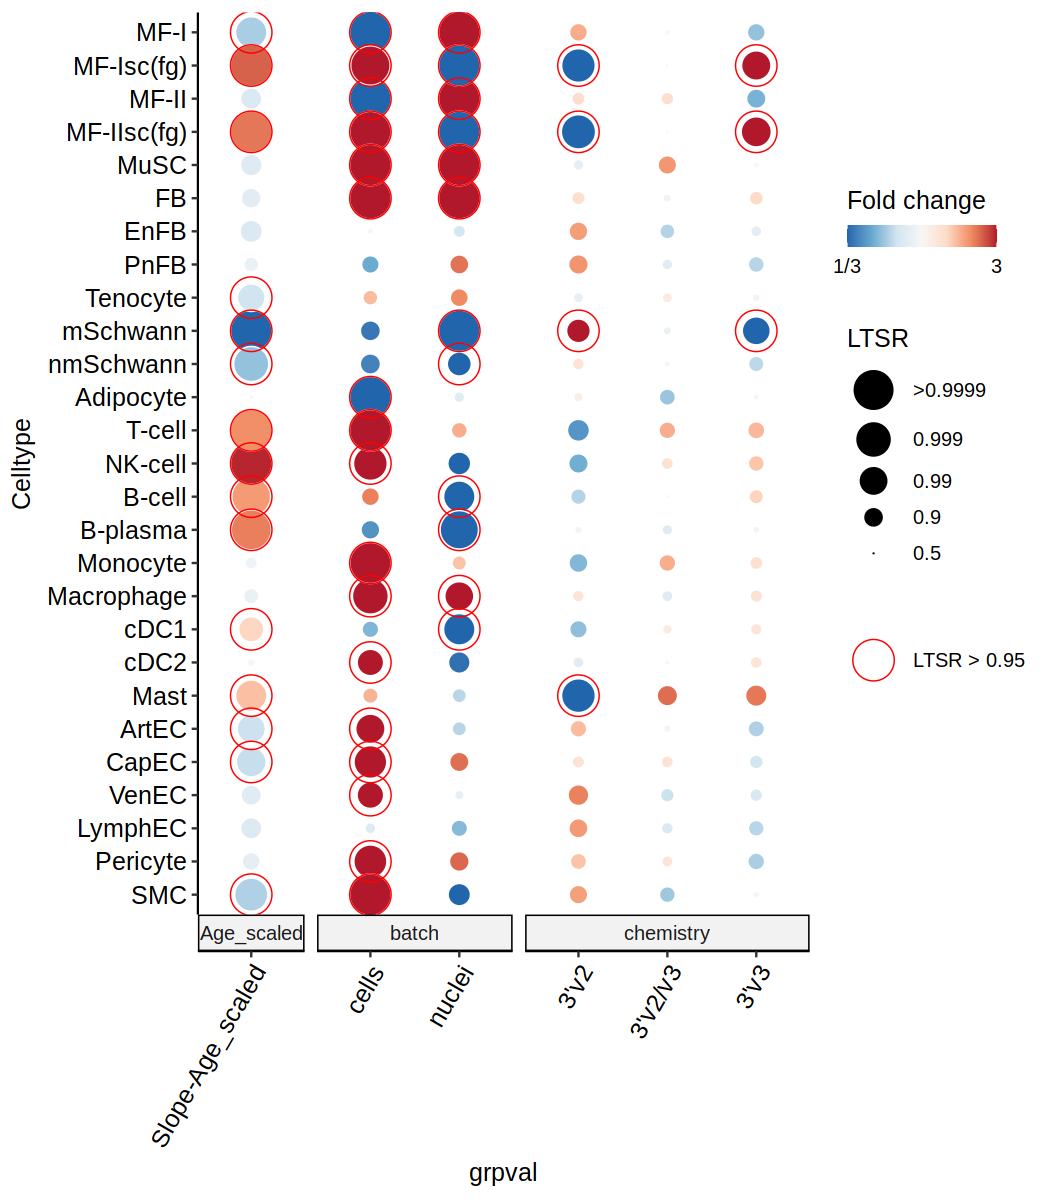

In [27]:
plt_gen = plot_ranef(result_gen$ranef, vars=list(Age_scaled = c('Slope-Age_scaled'), batch = c("cells", "nuclei"),
                                                 chemistry = c("3'v2", "3'v2/v3", "3'v3")), 
                     #batch = c("cells", "nuclei"),  
                     celltypes = celltype_order_gen,
                     celltype_order = rev(celltype_order_gen),
                     #references = list(Age_bin = 'young', batch = 'cells'), 
                     highlightLtsr = 0.95) + theme_pubr(legend = "right") +
   theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
         axis.text.x=element_text(angle=60, vjust=1, hjust=1))
plt_gen

In [36]:
fwrite(plt_gen$data, paste0(source_files, 'Fig1d_source_file.csv'))

## Supplementary covariate analysis

### 1. Plot distribution of different covariates

In [37]:
donor_tb = unique(obs_tbl2[,c("DonorID", "Sex", "Age", "Age_group", "Donor_type", "Ventilation_time(days)", "BMI", "BMI_type", "batch")])
donor_tb[, value:=1]
donor_tb[, BMI_type:=factor(BMI_type, levels = rev(c("underweight","healthy", "overweight", "obese")))]
plt_bmi_distr = ggplot(donor_tb, aes(fill=BMI_type,  x=Age_group, y = value)) + 
    geom_bar(position="stack", stat="identity") + facet_grid(~batch) + labs(x = "Age group", y = "No of donors") + 
theme_pubr(base_size = 14) 

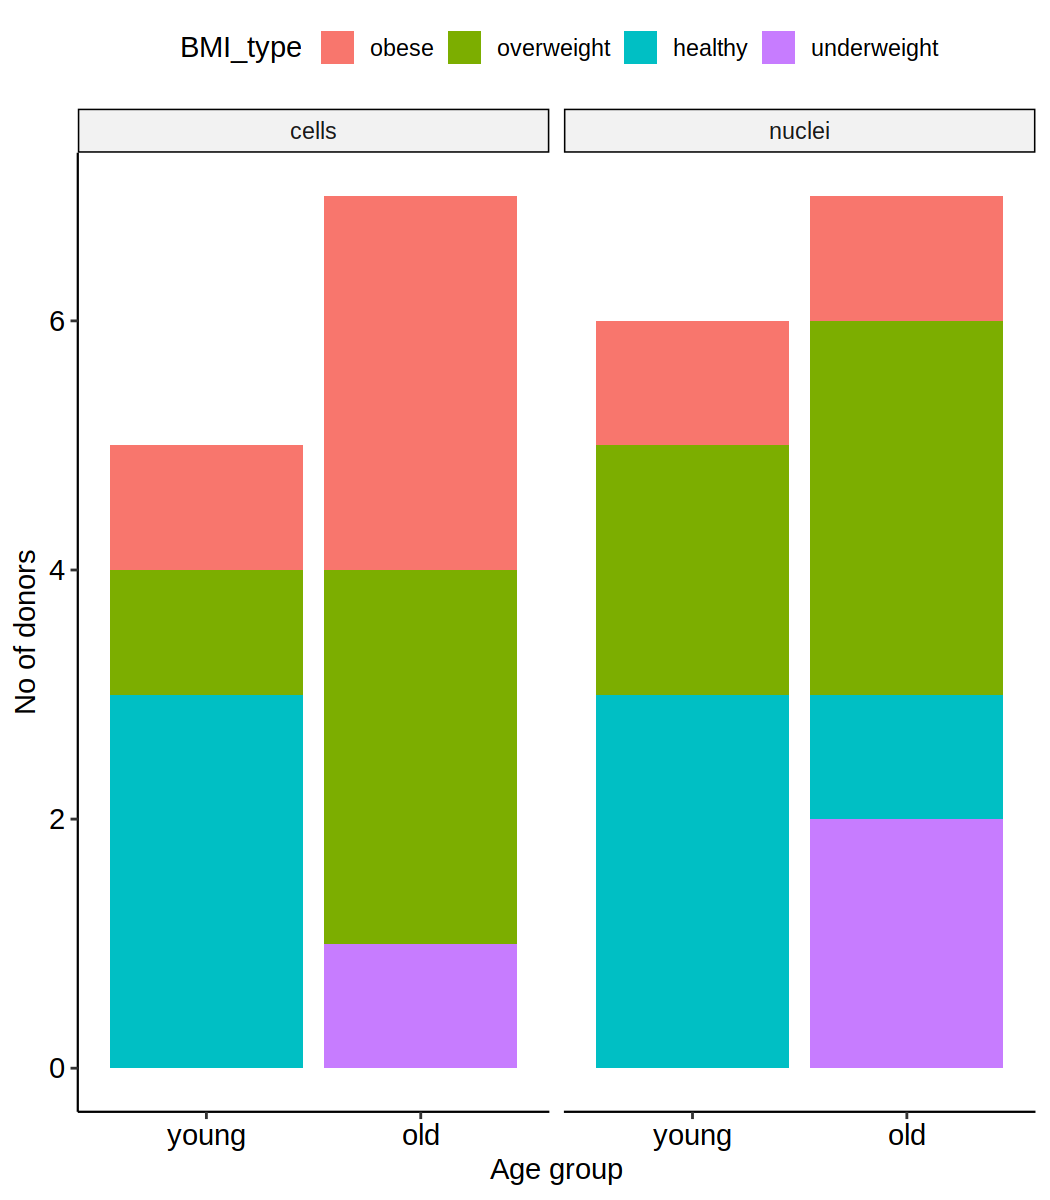

In [38]:
plt_bmi_distr

In [18]:
ggsave(filename = "/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/figures/BMI_distribution.pdf",plt_bmi_distr,
       width = 4, height =3.5)

In [39]:
plt_vent = ggplot(donor_tb, aes(x=Age_group, y = `Ventilation_time(days)`, shape = Age_group)) + 
geom_jitter(position=position_jitter(0.2),  size = 5) + 
     facet_grid(~batch) + labs(x = "Age group", y = "Ventilation time (days)") + scale_shape_manual(values=c(1,17)) +  theme_pubr() 
plt_vent = plt_vent + stat_summary(fun.data=mean_sdl, geom="pointrange", color="red")


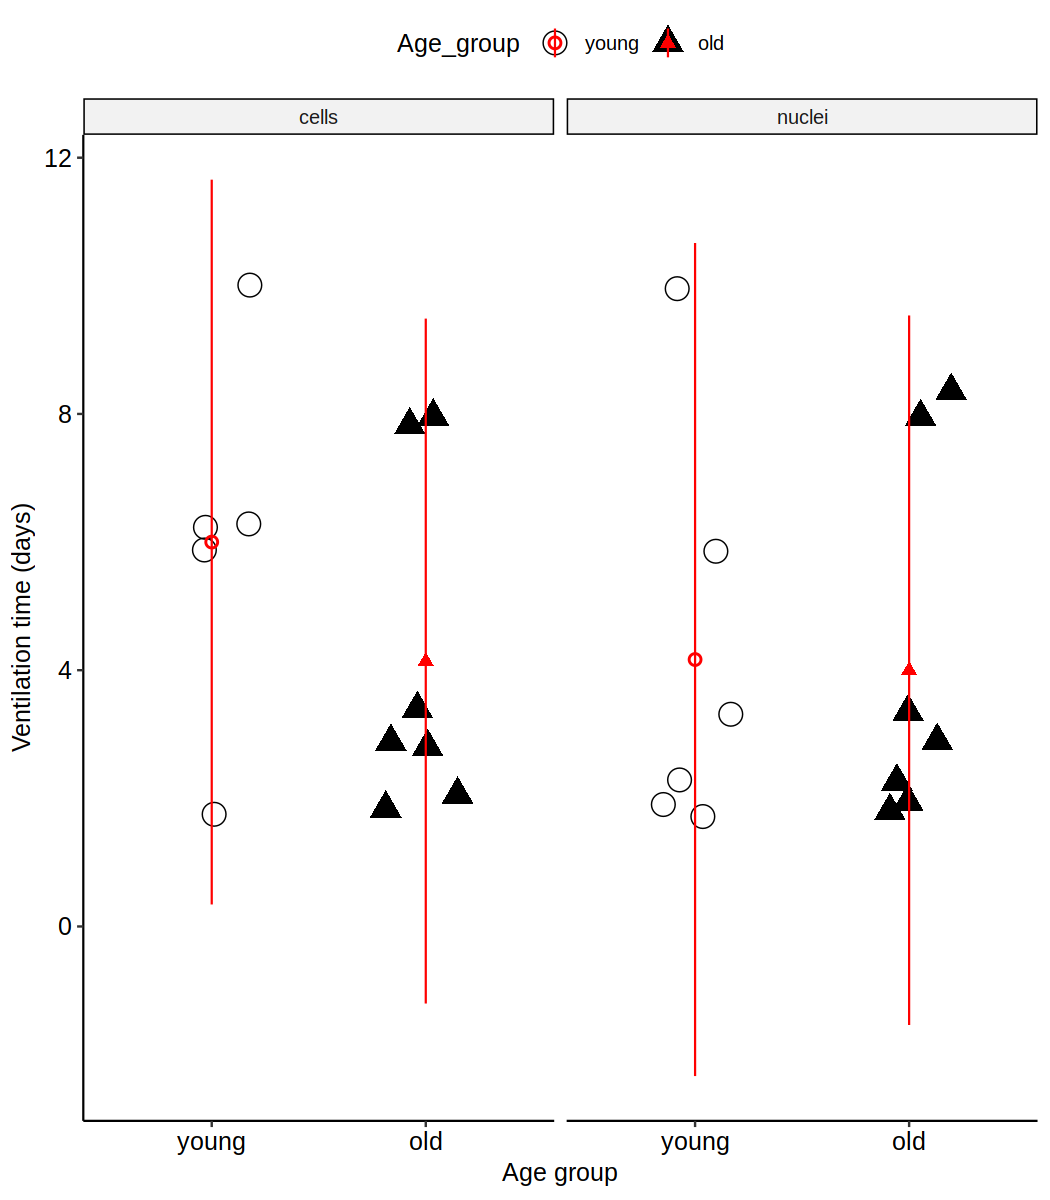

In [40]:
plt_vent

In [21]:
ggsave(filename = "/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/figures/Ventilation_distribution.pdf",plt_vent,
       width = 4, height =3.5)

In [41]:
t.test(donor_tb[Age_group == 'young']$`Ventilation_time(days)`,
      donor_tb[Age_group == 'old']$`Ventilation_time(days)`)


	Welch Two Sample t-test

data:  donor_tb[Age_group == "young"]$`Ventilation_time(days)` and donor_tb[Age_group == "old"]$`Ventilation_time(days)`
t = 0.80122, df = 19.741, p-value = 0.4325
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.490993  3.348136
sample estimates:
mean of x mean of y 
 5.000000  4.071429 


In [42]:
t.test(donor_tb[(batch == 'cells') & (Age_group == 'young')]$`Ventilation_time(days)`,
      donor_tb[(batch == 'cells') & (Age_group == 'old')]$`Ventilation_time(days)`)


	Welch Two Sample t-test

data:  donor_tb[(batch == "cells") & (Age_group == "young")]$`Ventilation_time(days)` and donor_tb[(batch == "cells") & (Age_group == "old")]$`Ventilation_time(days)`
t = 1.1473, df = 8.4403, p-value = 0.2828
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.842114  5.556399
sample estimates:
mean of x mean of y 
 6.000000  4.142857 


In [43]:
t.test(donor_tb[(batch == 'nuclei') & (Age_group == 'young')]$`Ventilation_time(days)`,
      donor_tb[(batch == 'nuclei') & (Age_group == 'old')]$`Ventilation_time(days)`)


	Welch Two Sample t-test

data:  donor_tb[(batch == "nuclei") & (Age_group == "young")]$`Ventilation_time(days)` and donor_tb[(batch == "nuclei") & (Age_group == "old")]$`Ventilation_time(days)`
t = 0.098615, df = 9.9469, p-value = 0.9234
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.601778  3.935111
sample estimates:
mean of x mean of y 
 4.166667  4.000000 


### 2. Analyze ventilation effect (length of hospital stay as a "proxy")

##### a) Single-cell data: use ventilation as continuous variable

In [72]:
result_vent_sc_chem <- CellTypeCompositionAnalysis(
    obs_tbl3[batch == 'cells'],
   colSample = 'SampleID',
   colCelltype = 'annotation_level0',
  colVarCats=c('chemistry'), 
  #colVarCats = c(),
   colVarNums = c('Ventilation_scaled', 'Age_scaled'),
   extra_term = c(),
    save='output'
)

input prepared
I(Y) ~ (1|Celltype)+Ventilation_scaled+Age_scaled+(1|SampleID)+(1|chemistry)+(Ventilation_scaled-1|Celltype)+(Age_scaled-1|Celltype)+(1|SampleID:Celltype)+(1|chemistry:Celltype)
model constructed
model fitted


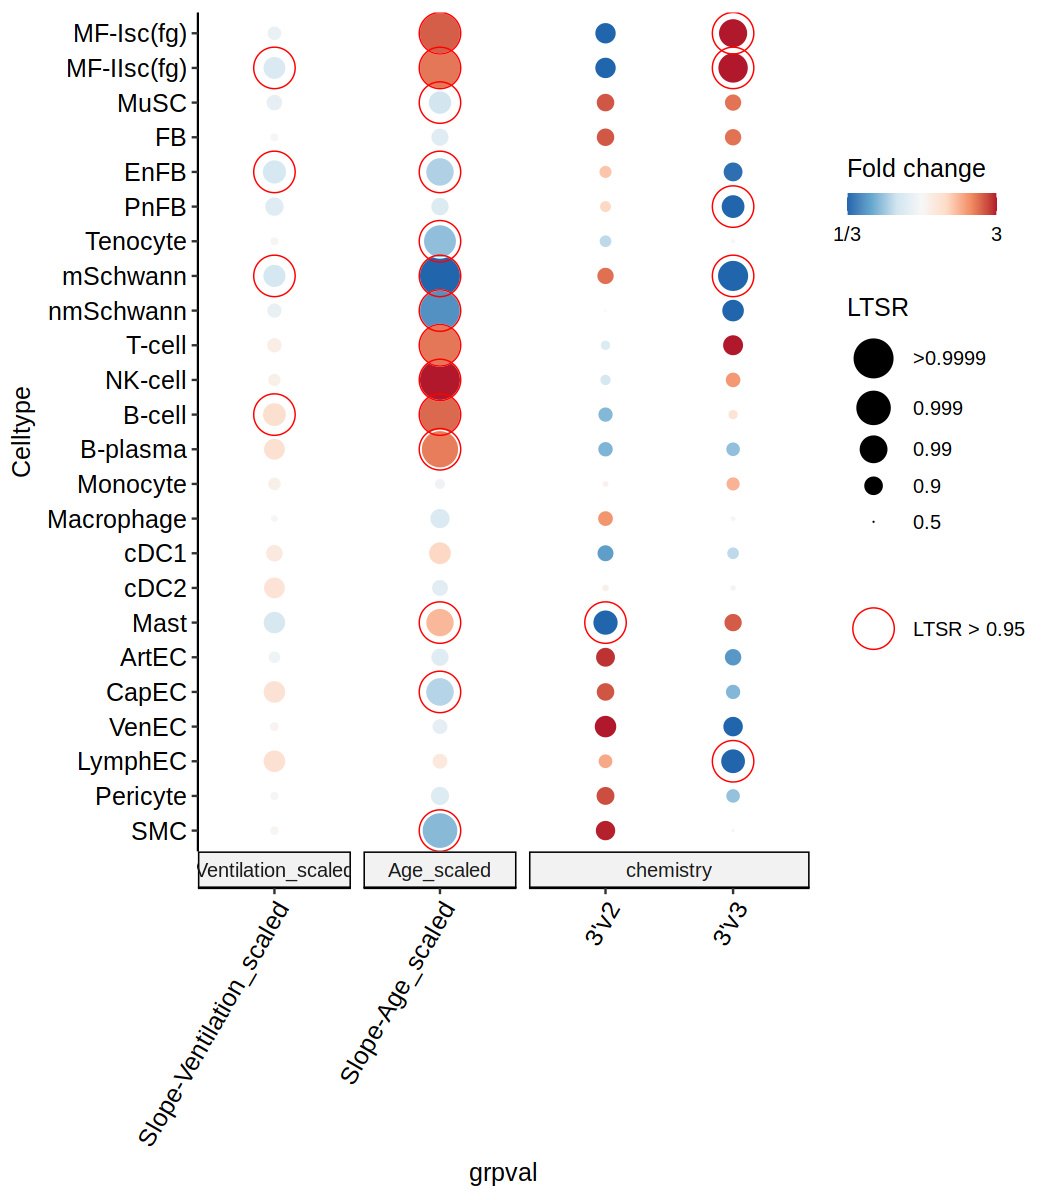

In [73]:
plt_vent_sc_chem = plot_ranef(result_vent_sc_chem$ranef, vars=list(Ventilation_scaled = c("Slope-Ventilation_scaled"),
                                                                   Age_scaled = c("Slope-Age_scaled"), 
                                                                   chemistry = c("3'v2", "3'v3")),
           celltypes =  celltype_order_sc,           
           celltype_order = rev(celltype_order_sc),
           maxFC=3, highlightLtsr = 0.95) + theme_pubr(legend = "right", x.text.angle = 60)
  # theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), axis.text.y =
  #          element_text(angle=45, vjust=0.5, hjust=1)) + theme_pubr(legend = "right", x.text.angle = 60) 
plt_vent_sc_chem

In [74]:
ggsave(paste0(figures_path, "Vent_scell_age_chem_effect_subset.pdf"), plt_vent_sc_chem)

Saving 6.67 x 6.67 in image


##### b) Single-cell data: use ventilation as categorical variable (works worse, not shown in SI)

In [80]:
result_vent_cat_sc_chem <- CellTypeCompositionAnalysis(
    obs_tbl3[batch == 'cells'],
   colSample = 'SampleID',
   colCelltype = 'annotation_level0',
  colVarCats=c('Ventilation_cat', 'chemistry'), 
  #colVarCats = c(),
   colVarNums = c('Age_scaled'),
   extra_term = c(),
    save='output'
)

input prepared
I(Y) ~ (1|Celltype)+Age_scaled+(1|SampleID)+(1|Ventilation_cat)+(1|chemistry)+(Age_scaled-1|Celltype)+(1|SampleID:Celltype)+(1|Ventilation_cat:Celltype)+(1|chemistry:Celltype)
model constructed


boundary (singular) fit: see help('isSingular')



model fitted


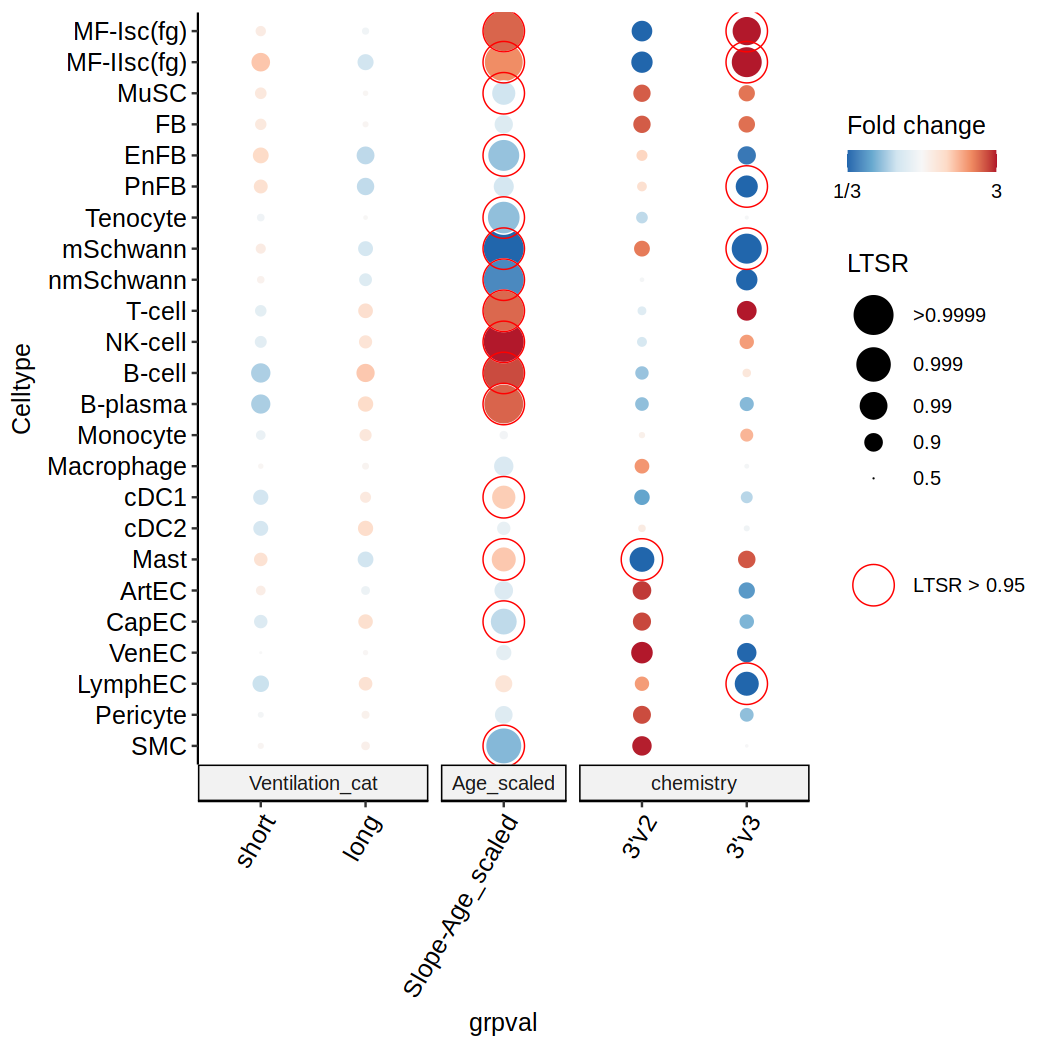

In [82]:
plt_vent_cat_sc_chem = plot_ranef(result_vent_cat_sc_chem$ranef, vars=list(Ventilation_cat = c("short", "long"),
                                                                   Age_scaled = c("Slope-Age_scaled"), 
                                                                   chemistry = c("3'v2", "3'v3")),
           celltypes =  celltype_order_sc,           
           celltype_order = rev(celltype_order_sc),
           maxFC=3, highlightLtsr = 0.95) + theme_pubr(legend = "right", x.text.angle = 60)
  # theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), axis.text.y =
  #          element_text(angle=45, vjust=0.5, hjust=1)) + theme_pubr(legend = "right", x.text.angle = 60) 
plt_vent_cat_sc_chem

##### c) Single-nuclei data: use ventilation as continuous (works worse, not shown in SI)

In [83]:
result_vent_scaled_nc <- CellTypeCompositionAnalysis(
    obs_tbl3[batch == 'nuclei'],
   colSample = 'SampleID',
   colCelltype = 'annotation_level0',
  #colVarCats=c('chemistry'), 
  colVarCats = c(),
   colVarNums = c('Age_scaled', 'Ventilation_scaled'),
   extra_term = c(),
    save='output'
)

input prepared
I(Y) ~ (1|Celltype)+Age_scaled+Ventilation_scaled+(1|SampleID)+(Age_scaled-1|Celltype)+(Ventilation_scaled-1|Celltype)+(1|SampleID:Celltype)
model constructed


boundary (singular) fit: see help('isSingular')



model fitted


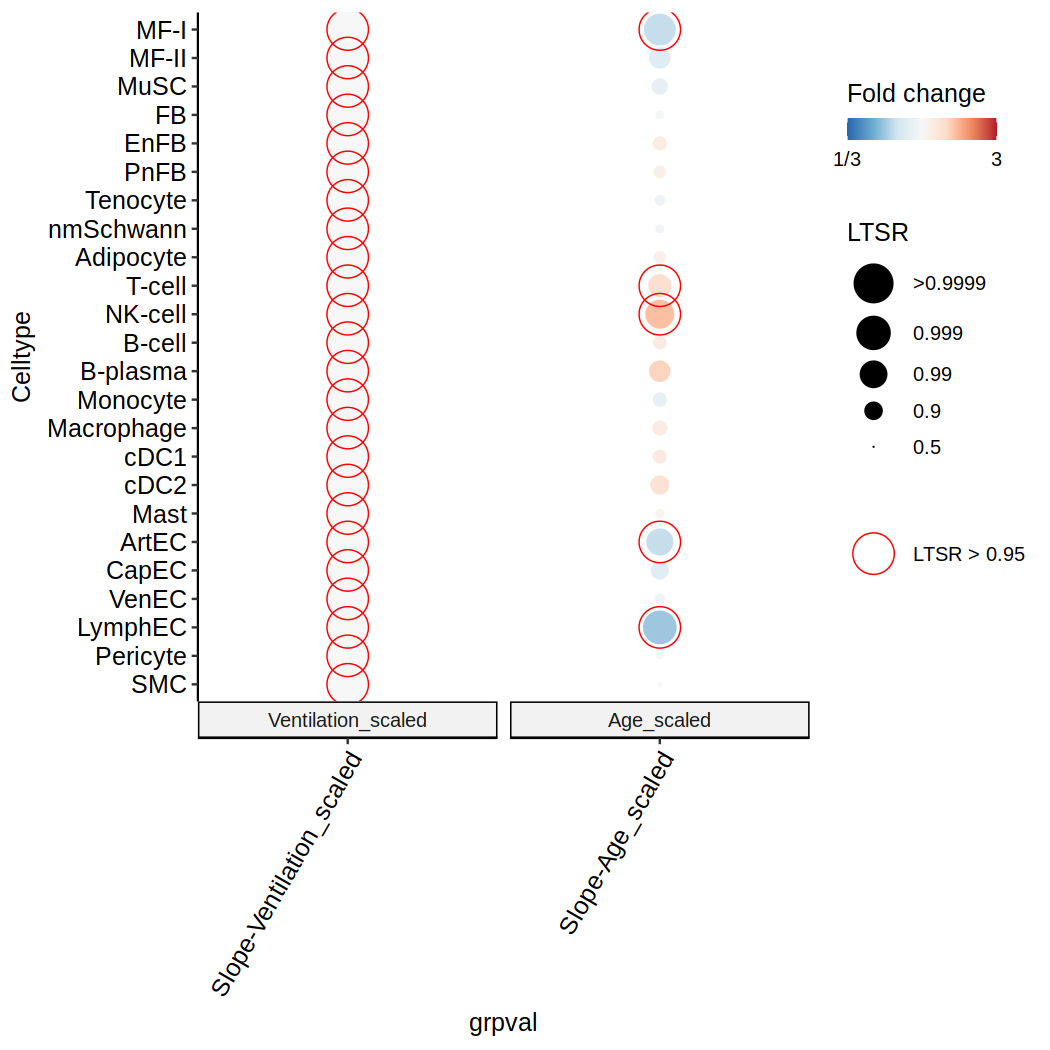

In [88]:
plt_vent_sc_nc1 = plot_ranef(result_vent_scaled_nc$ranef, vars=list(Ventilation_scaled = c("Slope-Ventilation_scaled"),
                                                                    Age_scaled = c("Slope-Age_scaled")),
           celltypes =  celltype_order_nc,           
           celltype_order = rev(celltype_order_nc),
           maxFC=3, highlightLtsr = 0.95) + 
   theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), axis.text.y =
            element_text(angle=45, vjust=0.5, hjust=1)) + theme_pubr(legend = "right", x.text.angle = 60)
plt_vent_sc_nc1

##### d) Single-nuclei data: use ventilation as categocial 

In [91]:
obs_tbl3$Ventilation_cat = factor(obs_tbl3$Ventilation_cat, levels = c("short", "long"))

In [75]:
result_vent_cat_chem_nc <- CellTypeCompositionAnalysis(
    obs_tbl3[batch == 'nuclei'],
   colSample = 'SampleID',
   colCelltype = 'annotation_level0',
  #colVarCats=c('chemistry'), 
  colVarCats = c('Ventilation_cat', 'chemistry'),
  colVarNums = c('Age_scaled'),
   extra_term = c(),
    save='output'
)

input prepared
I(Y) ~ (1|Celltype)+Age_scaled+(1|SampleID)+(1|Ventilation_cat)+(1|chemistry)+(Age_scaled-1|Celltype)+(1|SampleID:Celltype)+(1|Ventilation_cat:Celltype)+(1|chemistry:Celltype)
model constructed
model fitted


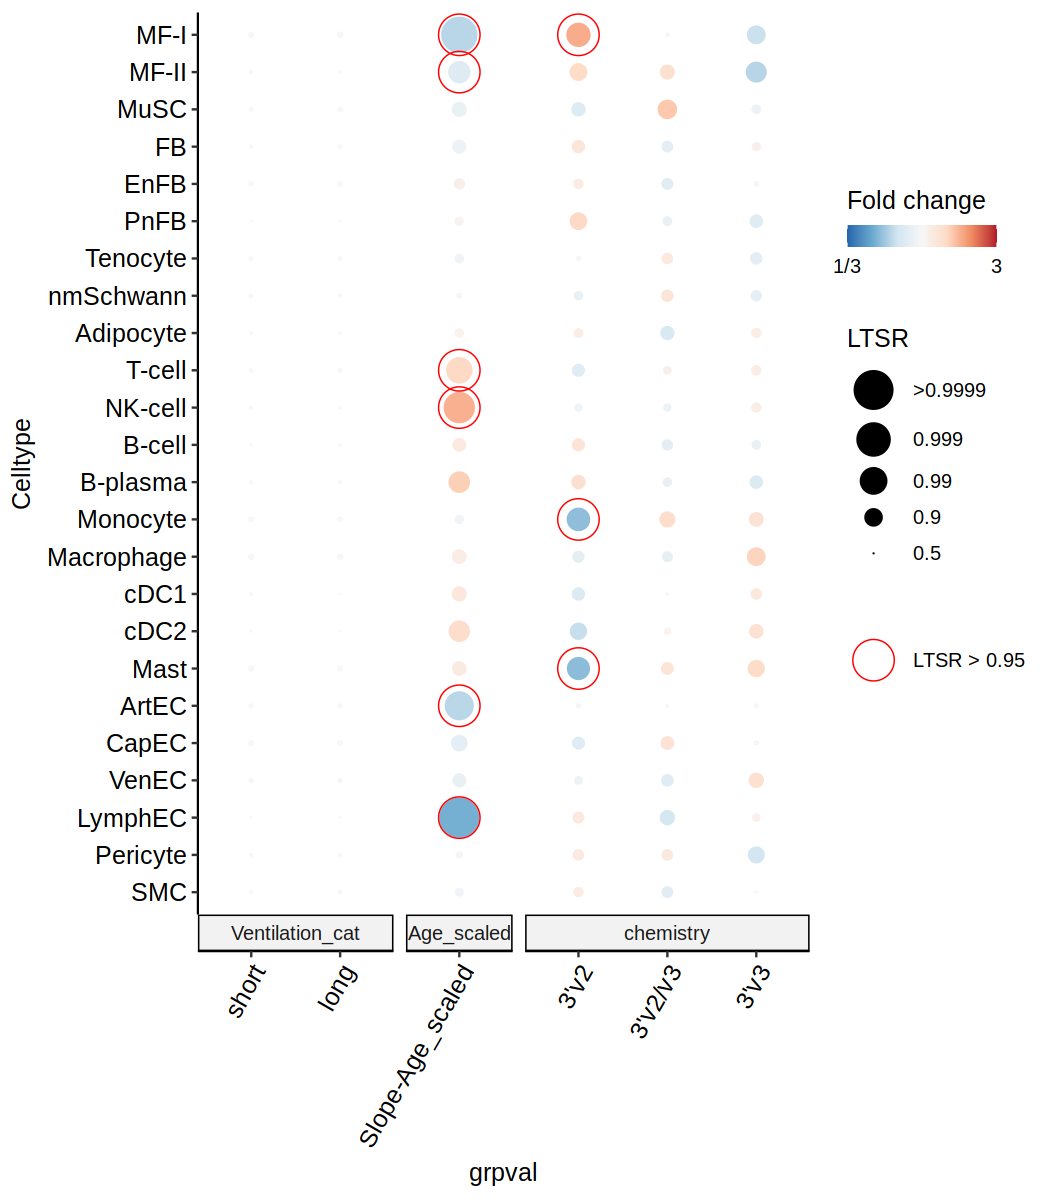

In [77]:
plt_vent_cat_chem_nc = plot_ranef(result_vent_cat_chem_nc$ranef, vars=list(Ventilation_cat = c("short", "long"), 
                                                                           Age_scaled = "Slope-Age_scaled", 
                                                                          chemistry = c("3'v2", "3'v2/v3", "3'v3")),
           celltypes =  celltype_order_nc,           
           celltype_order = rev(celltype_order_nc),
           maxFC=3, highlightLtsr = 0.95) + 
   theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), axis.text.y =
            element_text(angle=45, vjust=0.5, hjust=1)) + theme_pubr(legend = "right", x.text.angle = 60) 
plt_vent_cat_chem_nc

In [78]:
ggsave(paste0(figures_path, "Vent_snuclei_age_chem_effect_subset.pdf"), plt_vent_cat_chem_nc)

Saving 6.67 x 6.67 in image


### 3. Analyze BMI effect

##### a) Single-cell data

In [79]:
result_bmi_cat_chem_sc <- CellTypeCompositionAnalysis(
    obs_tbl3[batch == 'cells'],
   colSample = 'SampleID',
   colCelltype = 'annotation_level0',
  colVarCats=c('BMI_type', 'chemistry'), 
 # colVarCats = c(),
   colVarNums = c('Age_scaled'),
   extra_term = c(),
    save='output'
)

input prepared
I(Y) ~ (1|Celltype)+Age_scaled+(1|SampleID)+(1|BMI_type)+(1|chemistry)+(Age_scaled-1|Celltype)+(1|SampleID:Celltype)+(1|BMI_type:Celltype)+(1|chemistry:Celltype)
model constructed


boundary (singular) fit: see help('isSingular')



model fitted


In [80]:
plt_bmi_cat_chem_sc = plot_ranef(result_bmi_cat_chem_sc$ranef, vars=list(BMI_type = c('underweight','healthy','overweight','obese'),
                                                                         chemistry = c("3'v2", "3'v3"), Age_scaled = 'Slope-Age_scaled'),
       #chemistry = c("3'v2", "3'v3"), Donor_type = c('DCD', 'DBD'),
           celltypes = celltype_order_sc,celltype_order = rev(celltype_order_sc),
      #   references = list(BMI = "healthy", chemistry = c("3'v2")),
           maxFC=3, highlightLtsr = 0.95) +  theme_pubr(legend = "right")+
   theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
         axis.text.x=element_text(angle=45, vjust=1,hjust=1)) 

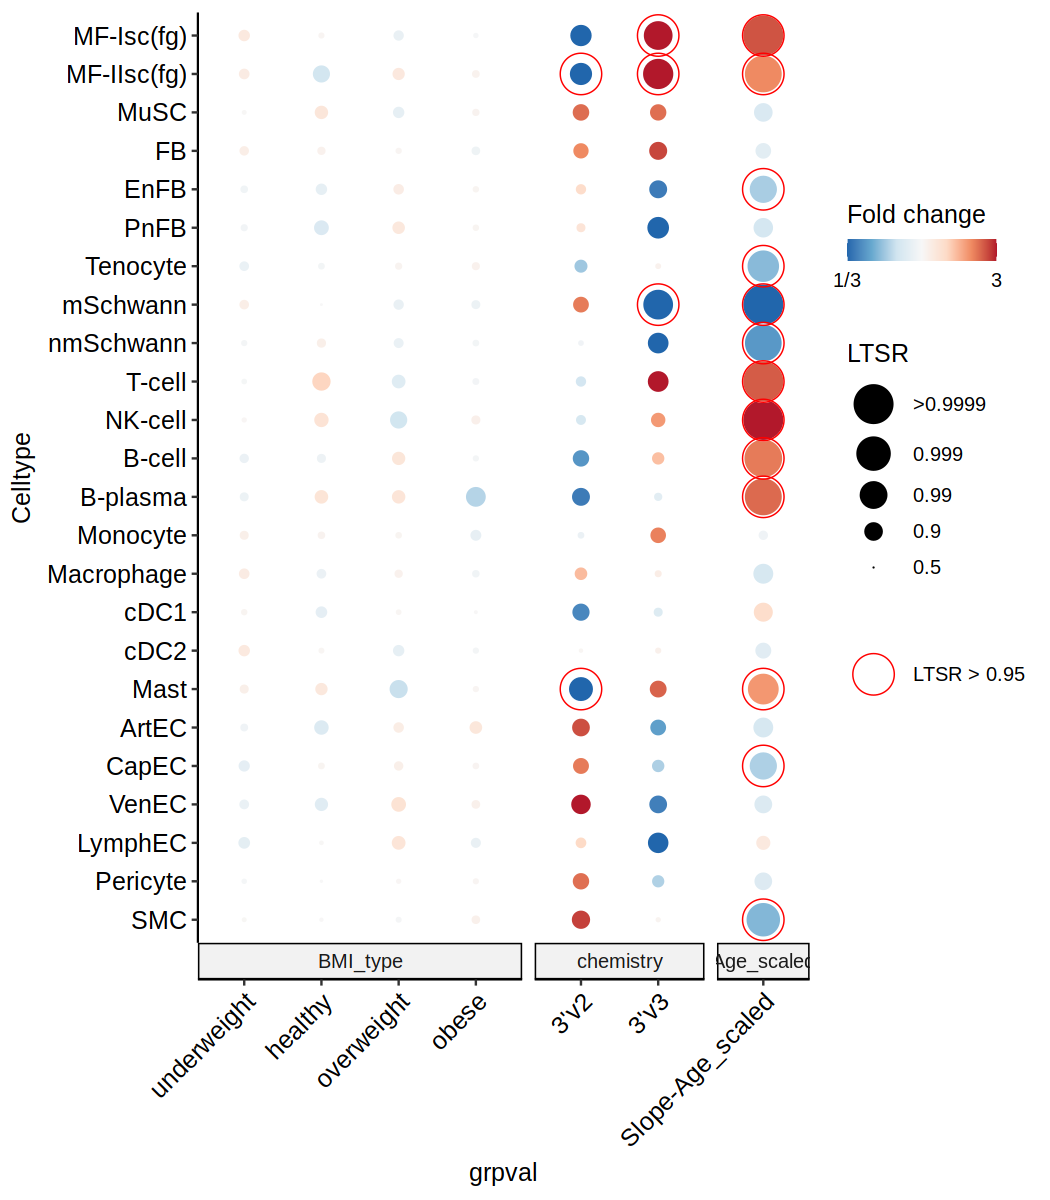

In [81]:
plt_bmi_cat_chem_sc

In [82]:
ggsave(paste0(figures_path, "BMI_scell_age_chem_effect_subset.pdf"), plt_bmi_cat_chem_sc)

Saving 6.67 x 6.67 in image


##### b) Single-nuclei data

In [86]:
result_bmi_cat_chem_sn <- CellTypeCompositionAnalysis(
    obs_tbl3[batch == 'nuclei'],
   colSample = 'SampleID',
   colCelltype = 'annotation_level0',
  colVarCats=c('BMI_type', 'chemistry'), 
 # colVarCats = c(),
   colVarNums = c('Age_scaled'),
   extra_term = c(),
    save='output'
)

input prepared
I(Y) ~ (1|Celltype)+Age_scaled+(1|SampleID)+(1|BMI_type)+(1|chemistry)+(Age_scaled-1|Celltype)+(1|SampleID:Celltype)+(1|BMI_type:Celltype)+(1|chemistry:Celltype)
model constructed
model fitted


In [87]:
plt_bmi_cat_chem_sn = plot_ranef(result_bmi_cat_chem_sn$ranef, vars=list(BMI_type = c('underweight','healthy','overweight','obese'),
                                                                         chemistry = c("3'v2","3'v2/v3","3'v3"), Age_scaled = 'Slope-Age_scaled'),
       #chemistry = c("3'v2", "3'v3"), Donor_type = c('DCD', 'DBD'),
           celltypes = celltype_order_nc,celltype_order = rev(celltype_order_nc),
      #   references = list(BMI = "healthy", chemistry = c("3'v2")),
           maxFC=3, highlightLtsr = 0.95) +  theme_pubr(legend = "right")+
   theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
         axis.text.x=element_text(angle=45, vjust=1,hjust=1)) 

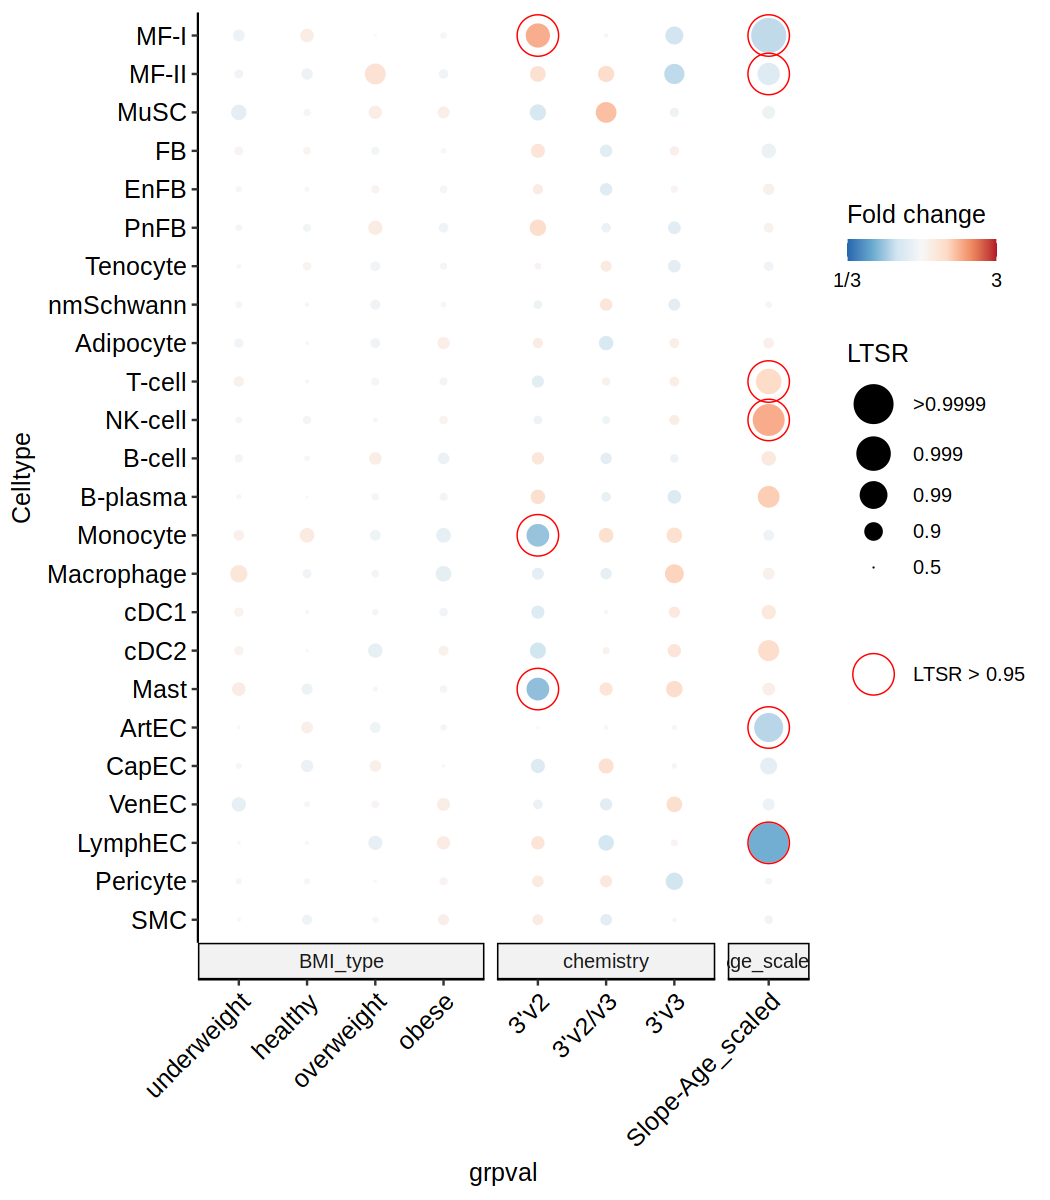

In [88]:
plt_bmi_cat_chem_sn

In [89]:
ggsave(paste0(figures_path, "BMI_snuclei_age_chem_effect_subset.pdf"), plt_bmi_cat_chem_sn)

Saving 6.67 x 6.67 in image


### 4. Analyze Sex effect

In [144]:
result_sex_chem_sn <- CellTypeCompositionAnalysis(
    obs_tbl3[batch == 'nuclei'],
   colSample = 'SampleID',
   colCelltype = 'annotation_level0',
  colVarCats=c('Sex', 'chemistry'), 
 # colVarCats = c(),
   colVarNums = c('Age_scaled'),
   extra_term = c(),
    save='output'
)

input prepared
I(Y) ~ (1|Celltype)+Age_scaled+(1|SampleID)+(1|Sex)+(1|chemistry)+(Age_scaled-1|Celltype)+(1|SampleID:Celltype)+(1|Sex:Celltype)+(1|chemistry:Celltype)
model constructed
model fitted


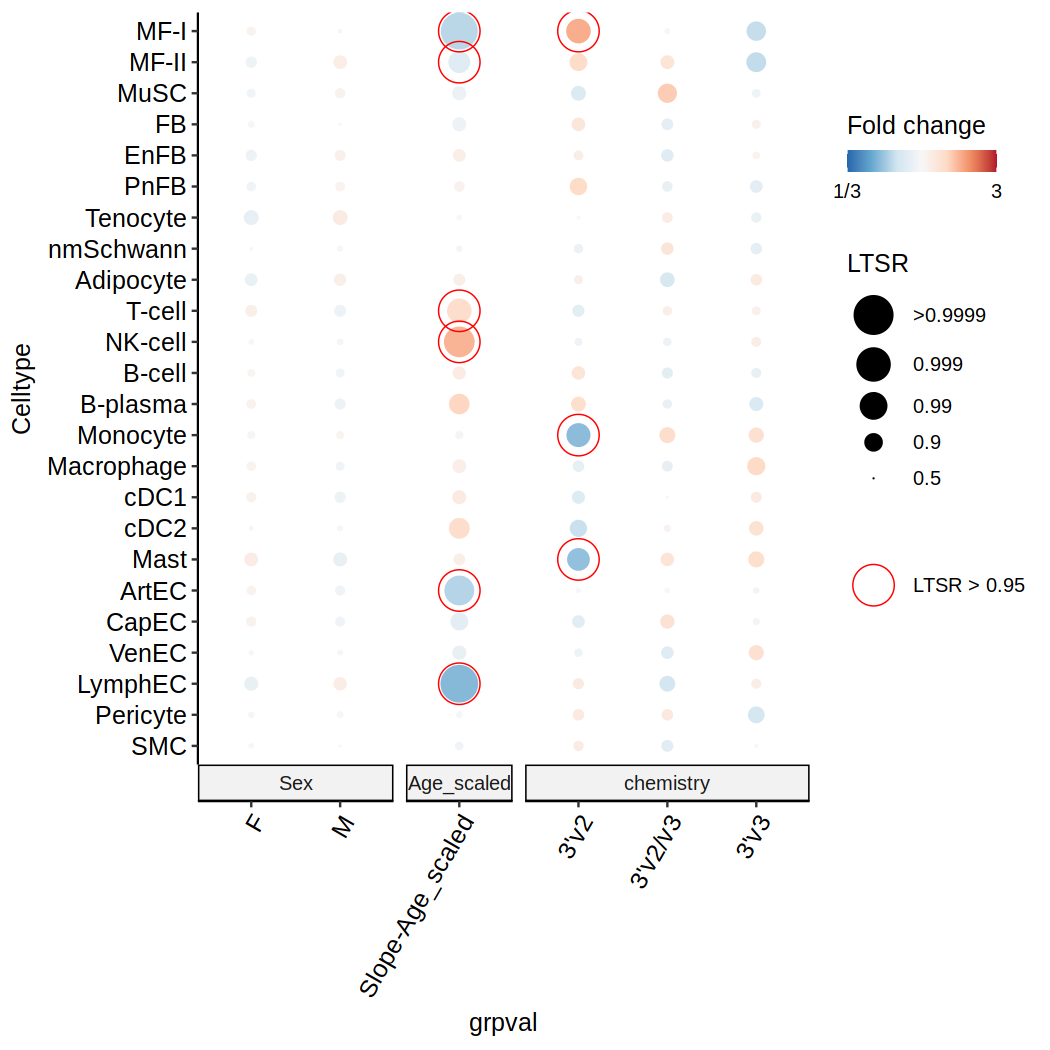

In [145]:
plt_sex_chem_sn = plot_ranef(result_sex_chem_sn$ranef,  vars=list(Sex = c('F', 'M'), 
                                                                     Age_scaled = 'Slope-Age_scaled',
                                                                     chemistry = c("3'v2", "3'v2/v3", "3'v3")), 
                                                                     #Sex = c("F", "M"),
                            celltypes = celltype_order_nc, 
                            celltype_order = rev(celltype_order_nc), maxFC=3, highlightLtsr = 0.95,) + 
theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) + 
theme_pubr(legend = "right", x.text.angle = 60)
plt_sex_chem_sn

In [96]:
obs_tbl3$Sex2Age = paste0(obs_tbl3$Sex, "-", obs_tbl3$Age_group)

In [97]:
unique(obs_tbl3$Sex2Age)

[1] "F-old"   "M-old"   "F-young" "M-young"

In [98]:
result_sex2age_chem_sn <- CellTypeCompositionAnalysis(
    obs_tbl3[batch == 'nuclei'],
   colSample = 'SampleID',
   colCelltype = 'annotation_level0',
  colVarCats=c('Sex2Age', 'chemistry'), 
 # colVarCats = c(),
   colVarNums = c('Age_scaled'),
  # extra_term = c('Sex', 'Age_group'),
    save='output'
)

input prepared
I(Y) ~ (1|Celltype)+Age_scaled+(1|SampleID)+(1|Sex2Age)+(1|chemistry)+(Age_scaled-1|Celltype)+(1|SampleID:Celltype)+(1|Sex2Age:Celltype)+(1|chemistry:Celltype)
model constructed
model fitted


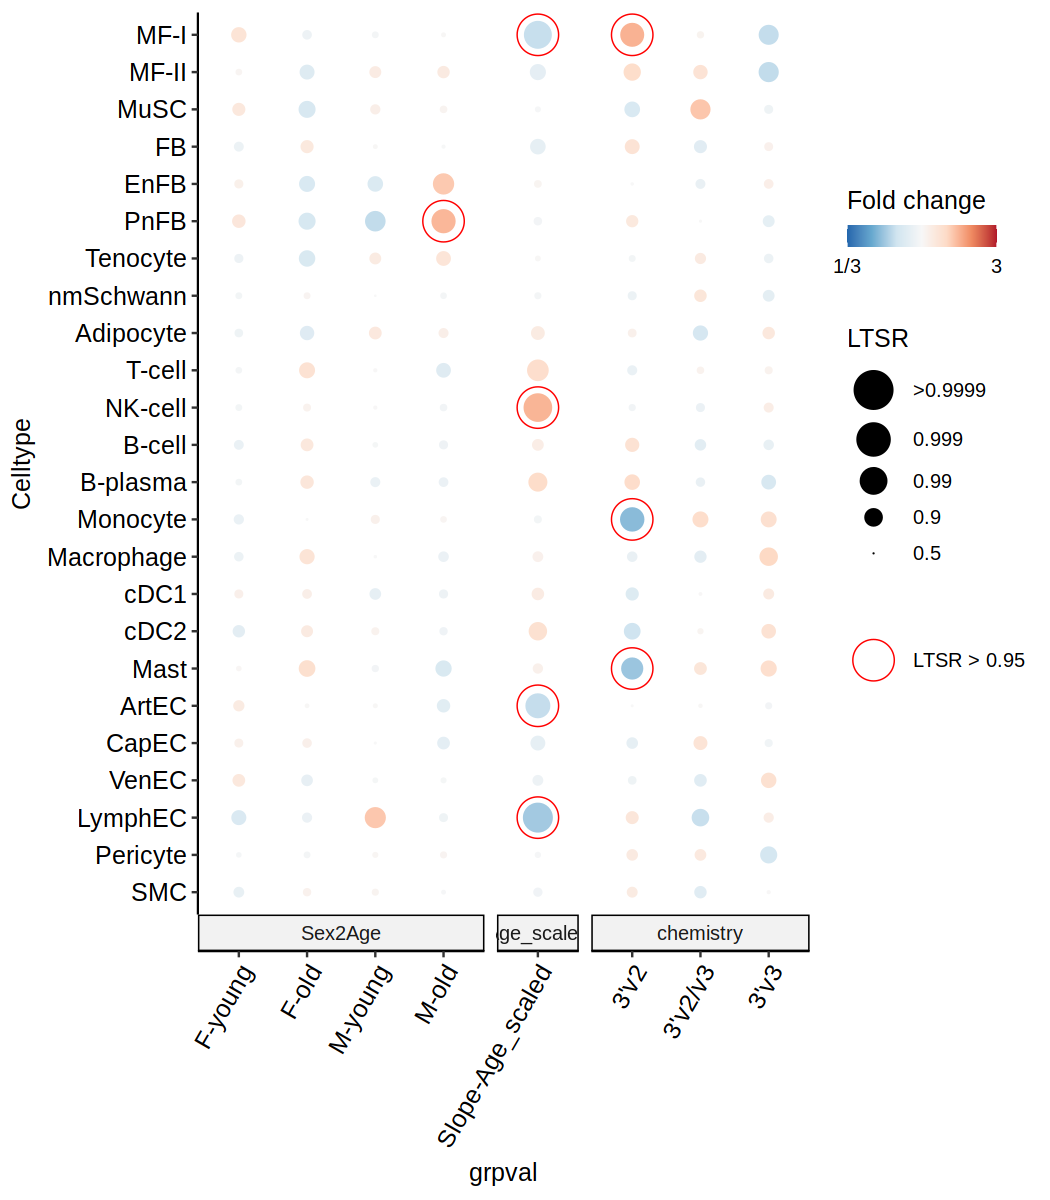

In [99]:
plt_sex_chem_sex2age_sn = plot_ranef(result_sex2age_chem_sn$ranef,  vars=list(Sex2Age = c('F-young', 'F-old', 
                                                                               'M-young', 'M-old'),  
                                                                     Age_scaled = 'Slope-Age_scaled',
                                                                     chemistry = c("3'v2", "3'v2/v3", "3'v3")), 
                                                                     #Sex = c("F", "M"),
                            celltypes = celltype_order_nc, 
                            celltype_order = rev(celltype_order_nc), maxFC=3, highlightLtsr = 0.95,) + 
theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank(), axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) + 
theme_pubr(legend = "right", x.text.angle = 60)
plt_sex_chem_sex2age_sn

In [100]:
ggsave(paste0(figures_path, "Sex2Age_snuclei_age_chem_effect.pdf"), plt_sex_chem_sex2age_sn)

Saving 6.67 x 6.67 in image
